In [4]:
#!pip install --upgrade tensorflow
#!pip install scikeras

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import GridSearchCV
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
#from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [6]:
# Load the Fashion MNIST dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [7]:
# Check the shape of the train dataset
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)

Train images shape: (60000, 28, 28)
Train labels shape: (60000,)


In [8]:
# Check the shape of the test dataset
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


In [9]:
# Preprocess the data
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

In [10]:
# Set the seed values for reproducibility
seed_value = 42
tf.random.set_seed(seed_value)
np.random.seed(seed_value)

In [11]:
# Define the function to create the CNN model
def create_model(num_layers):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))

    # Add the specified number of layers
    for _ in range(num_layers):
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [12]:
# Create a KerasClassifier for GridSearchCV
model = KerasClassifier(model=create_model, verbose=0)

# Define the hyperparameter grid
param_grid = {
    'model__num_layers': [1, 2],
    'epochs': [5, 10],
    'batch_size': [128, 256]
}

# Perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(train_images, train_labels)

In [13]:
# Print the best hyperparameters and corresponding accuracy
best_params = grid_result.best_params_
print("Best hyperparameters:", best_params)
print("Best accuracy:", grid_result.best_score_)

Best hyperparameters: {'batch_size': 128, 'epochs': 10, 'model__num_layers': 1}
Best accuracy: 0.9032833333333334


In [15]:
# Get the best model
best_model = grid_result.best_estimator_

# Set the seed value for TensorFlow and NumPy directly
tf.random.set_seed(seed_value)
np.random.seed(seed_value)

In [16]:
# Evaluate the best model on the test set
test_loss, test_acc = best_model.model_.evaluate(test_images, test_labels)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

313/313 [==============================] - 3s 10ms/step - loss: 0.2613 - accuracy: 0.9077
Test loss: 0.2613353729248047
Test accuracy: 0.9077000021934509


In [17]:
# Fit the model to capture the training history
history = best_model.model_.fit(train_images, train_labels, 
                                epochs=best_params['epochs'], 
                                batch_size=best_params['batch_size'], 
                                validation_data=(test_images, test_labels))

Epoch 1/10
469/469 [==============================] - 64s 136ms/step - loss: 0.1828 - accuracy: 0.9324 - val_loss: 0.2726 - val_accuracy: 0.9041
Epoch 2/10
469/469 [==============================] - 58s 124ms/step - loss: 0.1743 - accuracy: 0.9365 - val_loss: 0.2649 - val_accuracy: 0.9058
Epoch 3/10
469/469 [==============================] - 58s 124ms/step - loss: 0.1623 - accuracy: 0.9406 - val_loss: 0.2534 - val_accuracy: 0.9109
Epoch 4/10
469/469 [==============================] - 60s 127ms/step - loss: 0.1552 - accuracy: 0.9432 - val_loss: 0.2584 - val_accuracy: 0.9103
Epoch 5/10
469/469 [==============================] - 58s 124ms/step - loss: 0.1433 - accuracy: 0.9474 - val_loss: 0.2949 - val_accuracy: 0.9013
Epoch 6/10
469/469 [==============================] - 61s 129ms/step - loss: 0.1358 - accuracy: 0.9501 - val_loss: 0.2643 - val_accuracy: 0.9103
Epoch 7/10
469/469 [==============================] - 59s 125ms/step - loss: 0.1277 - accuracy: 0.9534 - val_loss: 0.2600 - val_ac

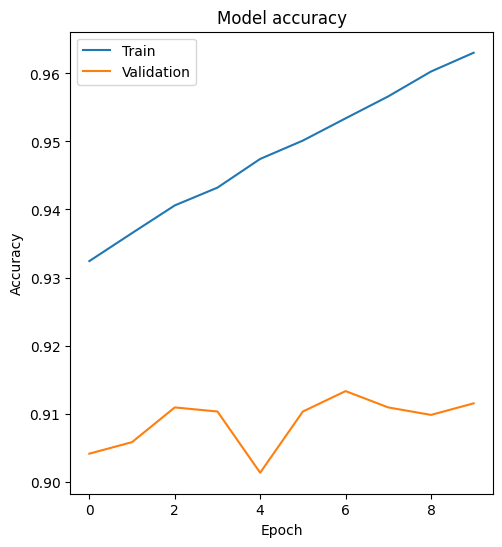

In [18]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

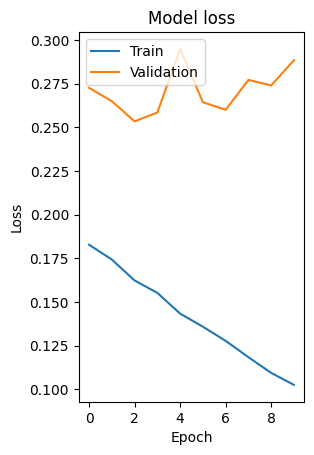

In [19]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

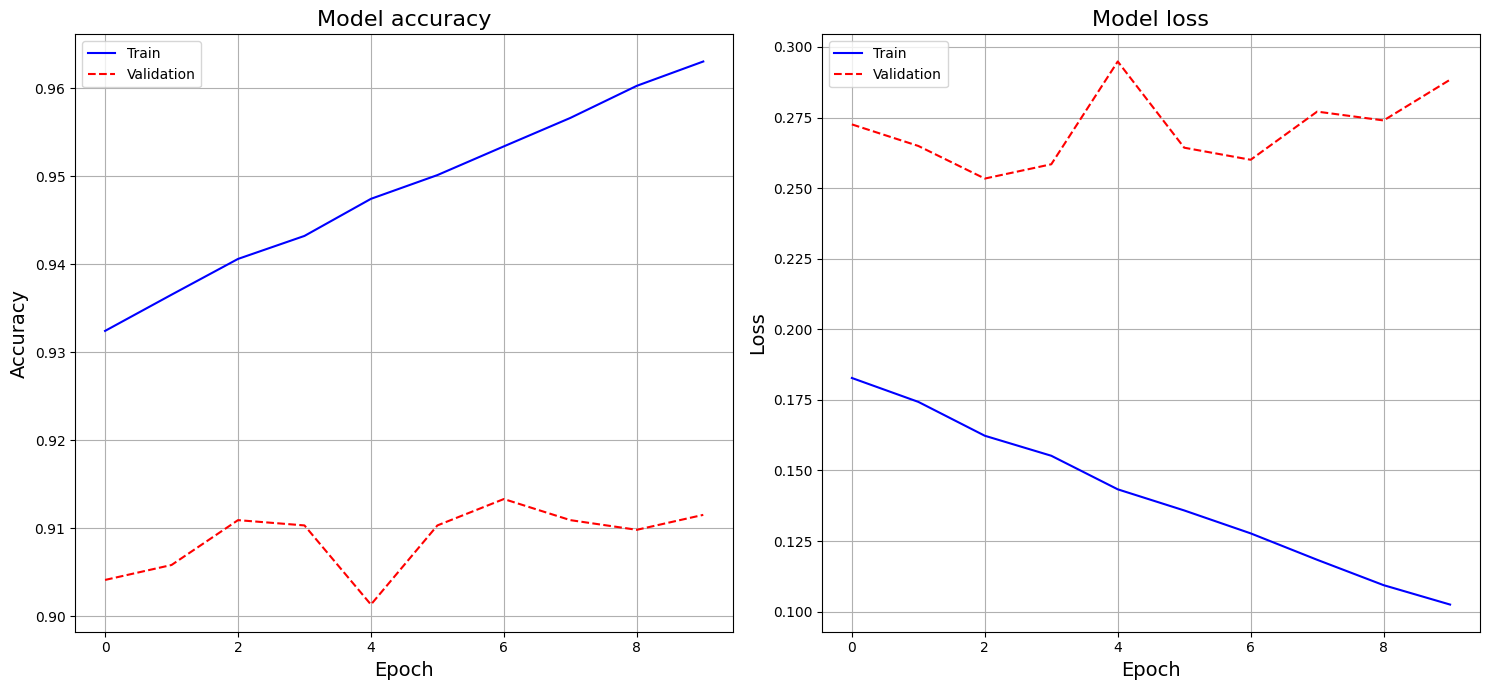

In [20]:
# Set up the matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 7))

# Plot training & validation accuracy values
axes[0].plot(history.history['accuracy'], linestyle='-', color='blue')
axes[0].plot(history.history['val_accuracy'], linestyle='--', color='red')
axes[0].set_title('Model accuracy', fontsize=16)
axes[0].set_ylabel('Accuracy', fontsize=14)
axes[0].set_xlabel('Epoch', fontsize=14)
axes[0].legend(['Train', 'Validation'], loc='upper left')
axes[0].grid(True)

# Plot training & validation loss values
axes[1].plot(history.history['loss'], linestyle='-', color='blue')
axes[1].plot(history.history['val_loss'], linestyle='--', color='red')
axes[1].set_title('Model loss', fontsize=16)
axes[1].set_ylabel('Loss', fontsize=14)
axes[1].set_xlabel('Epoch', fontsize=14)
axes[1].legend(['Train', 'Validation'], loc='upper left')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [21]:
# Predict the values from the test data
y_pred = best_model.model_.predict(test_images)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 

# Convert validation observations to one hot vectors
y_true = test_labels

print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes))

313/313 [==============================] - 3s 10ms/step
Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1000
           1       0.99      0.98      0.99      1000
           2       0.90      0.83      0.87      1000
           3       0.91      0.92      0.91      1000
           4       0.82      0.91      0.86      1000
           5       0.98      0.98      0.98      1000
           6       0.78      0.70      0.74      1000
           7       0.95      0.96      0.96      1000
           8       0.99      0.97      0.98      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



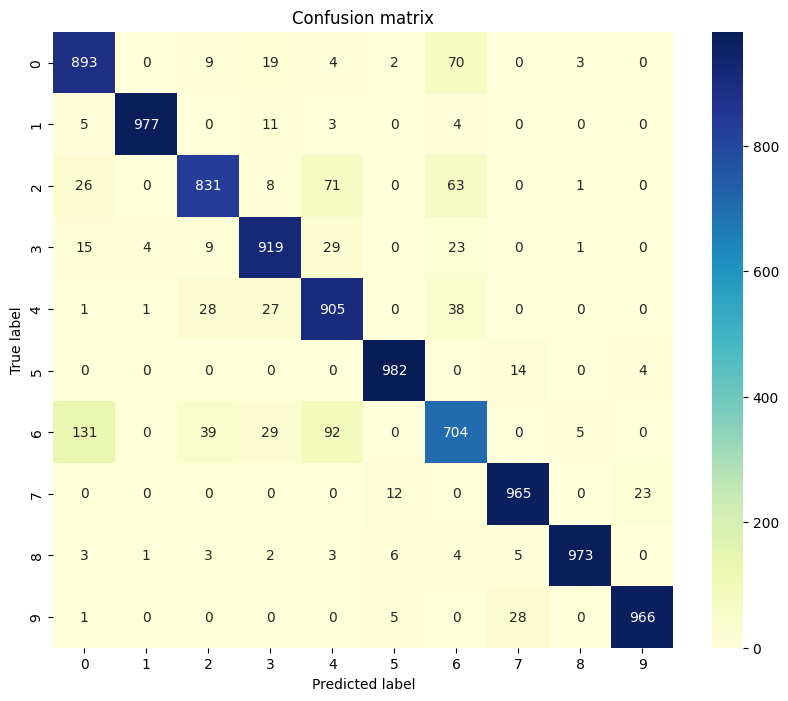

In [22]:
# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="YlGnBu");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()